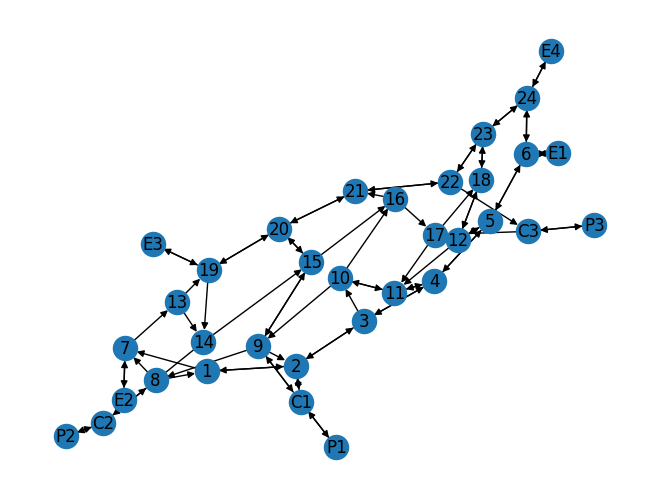

In [3]:
import networkx as nx

G = nx.DiGraph()

def bgc_layout():
    intersection_nodes = {
        #ENTRY NODES
        'E1': (600, 80), 
        'E2': (50, 50), 
        'E3': (100, 500),
        'E4': (650, 500),
        #PARKING NODES
        'P1': (150, 125),
        'P2': (75, 275),
        'P3': (450, 375),
        # CONNECTOR NODES (these are used to connect to parking nodes)
        'C1': (200, 125),
        'C2': (100, 275),
        'C3': (400, 375),
        #PROPER NODES
        # 1st BGC parallel nodes
        1: (100, 100),
        2: (200, 100),
        3: (300, 100),
        4: (400, 100),
        5: (500, 100),
        6: (600, 125),
        # 2nd Parallel nodes
        7: (50, 200),
        8: (100, 200),
        9: (200, 150),
        10: (300, 150),
        11: (400, 150),
        12: (500, 150),
        # 3rd Parallel Nodes
        13: (50, 300),
        14: (100, 300),
        15: (200, 350),
        16: (300, 350),
        17: (400, 350),
        18: (500, 350),
        # 4th Parallel Nodes
        19: (100, 400),
        20: (200, 400),
        21: (300, 400),
        22: (400, 400),
        23: (500, 400),
        24: (600, 375)
    }

    #('E2', 1)
    edge_list = [
        # TUPLE SYNTAX: (Node1, Node2, Capacity) -> (1, 2, 30). 30 being the capcity. If none entered, will be using a default value by the TrafficManager class
        # Important: Current rules for placing edges.
        # 1. For Entry (E) nodes, they must be placed first for each of the tuples
        # 2. For Parking (P) nodes, they must be placed first for each of the tuples
        # 3. //TODO something about connectors only connected to one direction
        # 4. If you want to implement edge capacity, add a third value to the tuple ex. (1, 2, 30) 30 -> Capacity
        # Entry / Exit Nodes
        ('E1', 6, 20),('E2', 7, 20),('E3', 19, 20),('E4', 24, 20),
        #Parking and connector nodes,
        ('P1', 'C1', 5), (2, 'C1', 3) , ('C1', 9, 4), (9, 'C1', 4), ('C1', 2, 3), #Three Parkade
        ('P2', 'C2', 5), ('C2', 8, 8), (14, 'C2', 2), #Uptown Mall Parking
        ('P3', 'C3', 5), (22, 'C3', 3), ('C3', 17, 4), #Gallery Parkade
        # Removed
        # (8, 'C2'),('C2', 14),
        # 1st Parallel Nodes
        (1, 2, 10),(1, 7, 10),
        (2, 1, 10),(2, 3, 10),
        (3, 2, 10),(3, 4, 10),(3, 10, 7),
        (4, 3, 10),(4, 5, 10),(4, 11, 7),
        (5, 4, 10),(5, 6, 10),(5, 12, 7),
        (6, 5, 10),(6, 24, 25),
        (7, 13, 10),
        (8, 1, 10),(8, 7, 7),
        (9, 2, 7),(9, 8, 15),(9, 15, 20),
        (10, 9, 10),(10, 11, 10),(10, 16, 20),
        (11, 4, 7),(11, 10, 10),
        (12, 5, 7),(12, 11, 10),(12, 18, 20),
        (13, 14, 7),(13, 19, 10),
        (14, 15, 15),
        (15, 9, 20),(15, 16, 10),(15, 20, 7),
        (16, 17, 10),(16, 21, 7),
        (17, 11, 20),(17, 18, 10),
        (18, 12, 20),(18, 23, 7),
        (19, 14, 10),(19, 20, 10),
        (20, 15, 7),(20, 19, 10),(20, 21, 10),
        (21, 20, 10),(21, 22, 10),
        (22, 21, 10),(22, 23, 10),
        (23, 18, 7),(23, 22, 10),(23, 24, 10),
        (24, 6, 25),(24, 23, 10)
    ]

    return intersection_nodes, edge_list

intersection_nodes, edge_list = bgc_layout()

entry_nodes = []
entry_edges = []
self_edges = {}

self_edges = {i: {'cars_occupied': [], 'weight': 0} for i in edge_list}

for index, pos in intersection_nodes.items():
    # Add index to the list of entries in the entry_nodes list.
    if "E" in str(index) or "P" in str(index):
        entry_nodes.append(index)
    G.add_node(index, pos=pos)

# Add edges to the graph.
for edges in edge_list:
    # Add edges to the entry edges list
    G.add_edge(edges[0], edges[1])
    if any("E" in str(edge) for edge in edges):
        #for now we will assume that the entry edge is at the first element
        entry_edges.append(edges)

        #add the inverse edge of the E's as well
        self_edges[(edges[1], edges[0])] = {'cars_occupied': [], 'weight': 0}
        G.add_edge(edges[1], edges[0])
    elif any("P" in str(edge) for edge in edges):
        if "P" in str(edges[0]): #this one is more likely to happen for now
            entry_edges.append((edges[0], edges[1]))

            #add the inverse edge of the P's as well
            self_edges[(edges[1], edges[0])] = {'cars_occupied': [], 'weight': 0}
            G.add_edge(edges[1], edges[0])

nx.draw(G, with_labels=True)

In [2]:
origin_node = 'E4'
next_destination_node = None
final_destination_node = 'P3'

def compute_shortest_path():
    global next_destination_node
    """
    Compute the car agent's shortest path using NetworkX's shortest_path function (default: Djikstra)
    """        
    # edge_weight = tm.get_edge_weight(self.origin_node, self.final_destination_node)
    # paths = nx.shortest_path(tm.G, self.origin_node, self.final_destination_node, weight='weight')
    paths = nx.dijkstra_path(G, origin_node, final_destination_node, weight='weight')
    print(f"Paths {paths}")
    # print(f"Car {self.index} from origin: {origin_node} paths: {paths[1:]}")

    node_paths = iter(paths[1:]) #ommitting first index, since it is already the origin
    next_destination_node = next(node_paths)

print(f"Origin: {origin_node}, Next Destination: {next_destination_node}")
compute_shortest_path()
print(f"Origin: {origin_node}, Next Destination: {next_destination_node}")

Origin: E4, Next Destination: None
Paths ['E4', 24, 23, 22, 'C3', 'P3']
Origin: E4, Next Destination: 24
